In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import random
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
import json
import imageio
import shap

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import warnings
import pickle
warnings.filterwarnings("ignore")

from src.data_assemble.wrap_data import *
from src.models.WindCNN import *
from src.data_assemble.wrap_data import *

# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/
random.seed(24)

In [2]:
path_to_data = os.path.join('data', 'nn_data')
st_split_dict = train_val_test_split(path_to_data, train = 0.5, val = 0.25, test = 0.25, verbose = True)
path_to_dump = os.path.join('data','nn_data')
X, y = extract_splitted_data(path_to_dump, st_split_dict)

{'Train': ['Туапсе', 'Краснодар, Круглик'], 'Val': ['Анапа'], 'Test': ['Приморско-Ахтарск']}


In [3]:
batch_size = 1024
with open(os.path.join('conf', 'conv_config.json')) as fs:
    args = json.load(fs)

In [4]:
logger = TensorBoardLogger(save_dir='logs/wind', name='windnet')
trainer = pl.Trainer(max_epochs=50,
                    gpus='1',
                    benchmark=True,
                    check_val_every_n_epoch=1,
)


dm = WindDataModule(X=X, y=y, batch_size=batch_size, downsample=False)
model = WindNetPL(args)

# chk_path = "./lightning_logs/version_13/checkpoints/epoch=35-step=288.ckpt"
chk_path = "lightning_logs/version_0"
chk_path = os.path.join(chk_path, "checkpoints", os.listdir(os.path.join(chk_path, "checkpoints"))[0])
model2 = WindNetPL.load_from_checkpoint(chk_path, args=args)
model2.eval()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


WindNetPL(
  (net): WindNet(
    (conv1): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc): Linear(in_features=800, out_features=2, bias=True)
    (net): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Flatten(start_dim=1, end_dim=-1)
      (6): Linear(in_features=800, out_features=2, bias=True)
      (7): Softmax(dim=None)
    )
  )
  (accuracy): Accuracy()
  (AUROC): AUROC()
  (precision_m): Precision()
  (recall): Recall()
  (F1): F1Score()
  (conf_matrix): ConfusionMatrix()
  (stats_scores): StatSco

# Shap

In [11]:
trainer.test(model2, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_AUROC_step        0.5980501174926758
      test_acc_step         0.9937020540237427
      test_f1_step          0.9968386888504028
        test_loss            0.66011318835999
   test_precision_step      0.9937020540237427
    test_recall_step                1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<bound method WindDataModule.test_dataloader of <src.data_assemble.wrap_data.WindDataModule object at 0x7fcb9d7565d0>>

In [15]:
batch = next(iter(dm.test_dataloader()))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model2, background)
shap_values = e.shap_values(test_images)

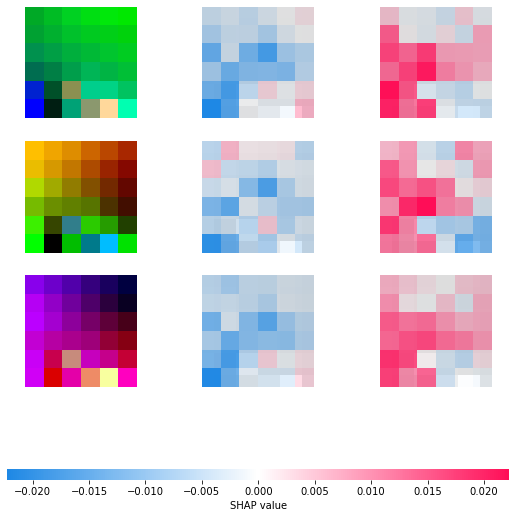

In [22]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

# Inferring on each pixel

In [5]:
# path_to_data = os.path.join('data', 'nn_data_grid_inference')
path_to_data = os.path.join('..', '..', 'a.galliamov', 'Wind', 'data', 'nn_data')
grid_inference_ = {}

for i, curr_pix in tqdm(enumerate(os.listdir(path_to_data))):
    X, y = extract_splitted_data(path_to_data, {'Grid': [curr_pix]})
    X_grid_t = torch.tensor(X["Grid"], device=model2.device).double()
    inference = model2(dm.transform(X_grid_t)).detach().cpu().numpy()
    grid_inference_[curr_pix] = inference

144it [00:53,  2.69it/s]


In [6]:
grid_inference = {}
for k in grid_inference_.keys():
    try:
        k1, k2 = k[1:-1].split(', ')
        k1 = int(k1)
        
        k2 = int(k2)
        grid_inference[(k1, k2)] = grid_inference_[k]
    except AttributeError:
        pass
del grid_inference_

In [7]:
keys = list(grid_inference.keys())
sorted_tmp = sorted(keys, key=lambda x: x[0])
shift_x = sorted_tmp[0][0] + 1
max_x = sorted_tmp[-1][0] + shift_x
sorted_tmp = sorted(keys, key=lambda x: x[1])
shift_y = sorted_tmp[0][1] + 1
max_y = sorted_tmp[-1][1] + shift_y
some_key = keys[0]
grid = np.zeros((grid_inference[some_key].shape[0], max_x, max_y))

for k in grid_inference.keys():
    grid[:, k[0], k[1]] = grid_inference[k][:, 1]

In [8]:
# start_date = pd.to_datetime('2006-01-01')
start_date = pd.to_datetime('2021-01-01')
str(start_date + pd.DateOffset(1) * 31)

'2021-02-01 00:00:00'

# Наложение экспоненциального сглдаживания на карты

In [9]:
exp_smooth = False
if exp_smooth:
    grid_new = np.zeros_like(grid)
    for i in range(grid.shape[0]):
        grid_new[i,:,:] = ewma_vectorized_2d(data=grid[i,:,:], alpha=0.7, axis=1)
        grid_new[i,:,:] = ewma_vectorized_2d(data=grid_new[i,:,:], alpha=0.7, axis=0)
else:
    grid_new = grid

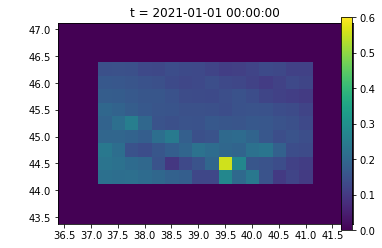

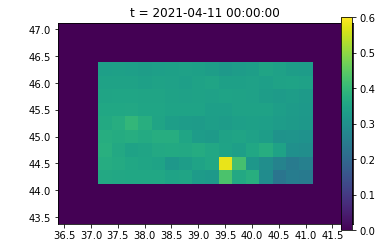

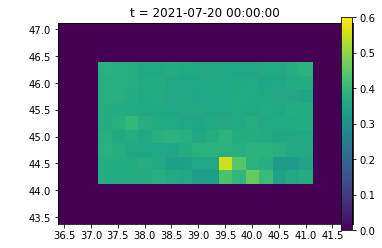

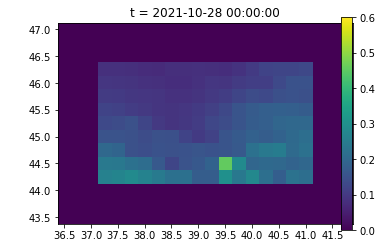

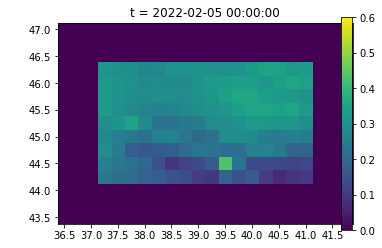

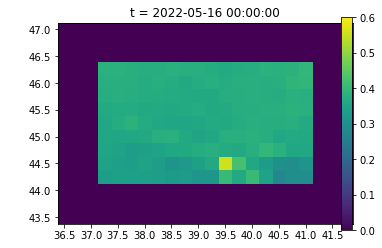

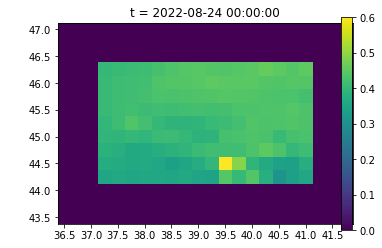

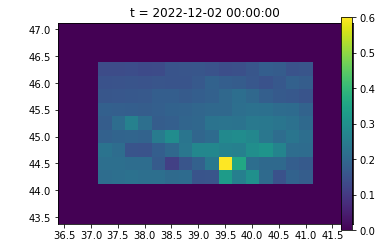

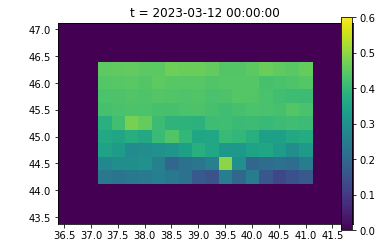

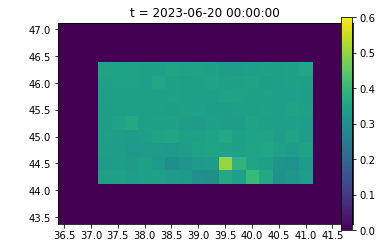

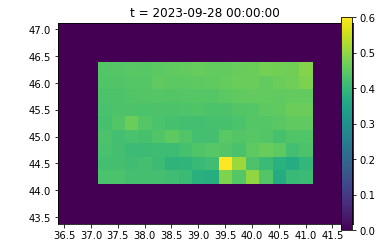

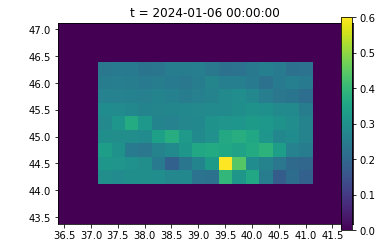

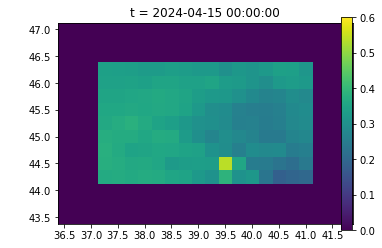

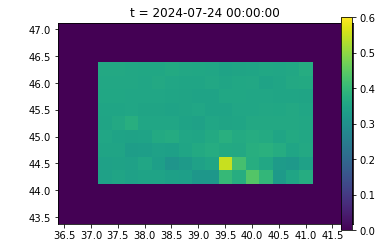

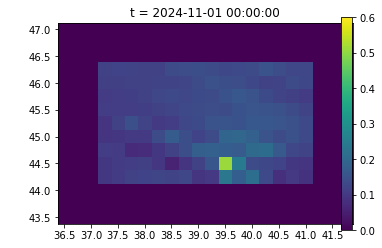

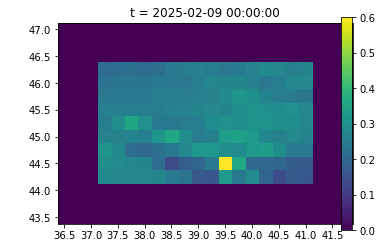

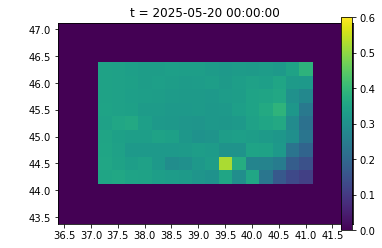

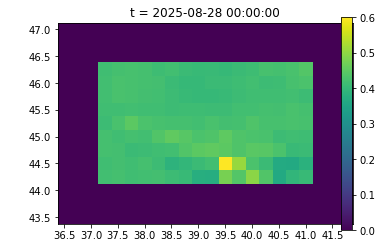

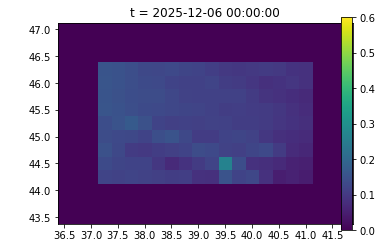

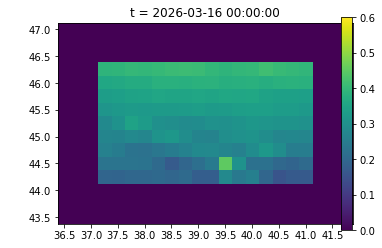

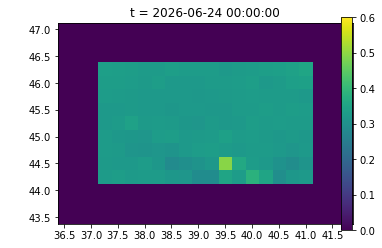

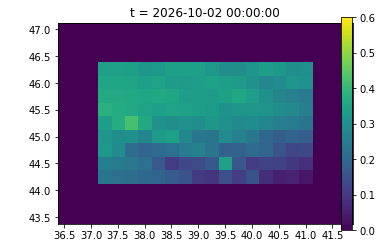

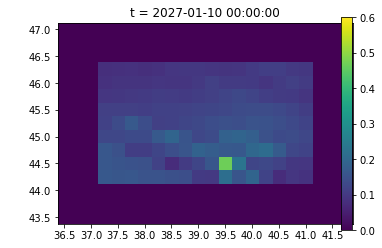

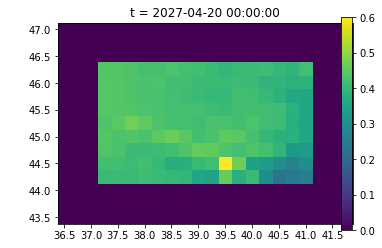

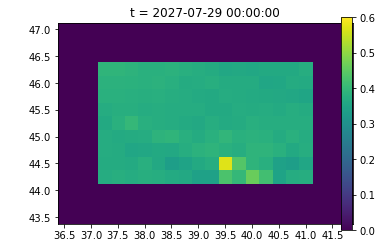

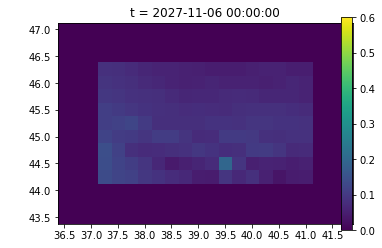

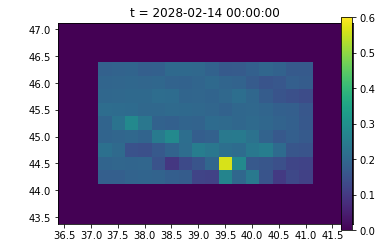

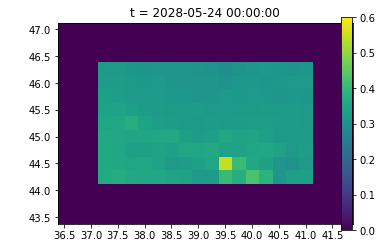

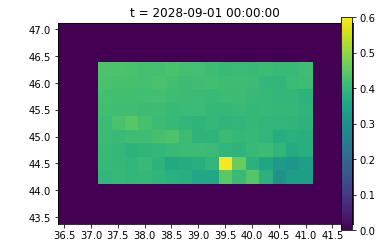

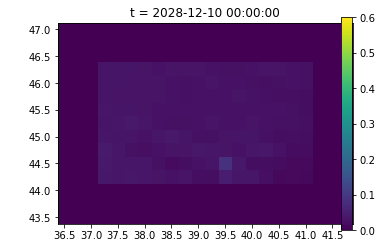

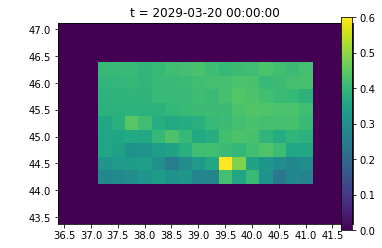

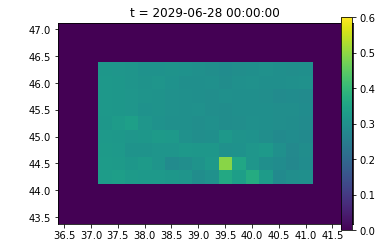

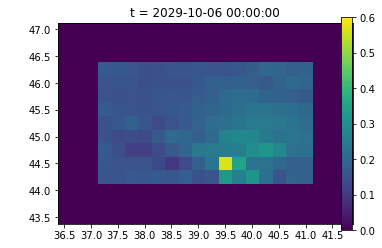

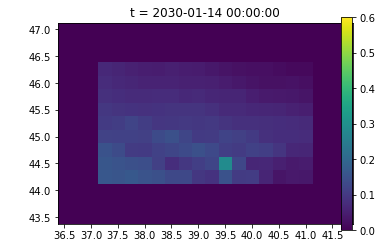

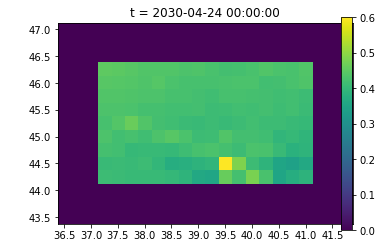

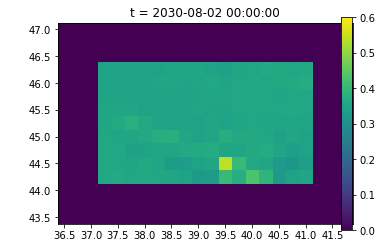

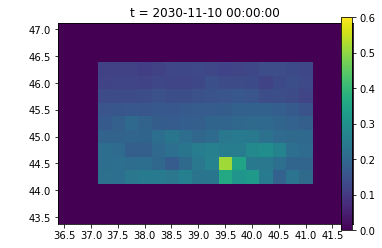

In [10]:
X = np.arange(36.5, 42.0, 0.5)#[36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5]
Y = np.arange(43.5, 47.5, 0.5)#[47.0, 46.5, 46.0, 45.5, 45.0, 44.5, 44.0, 43.5]


for t in list(range(grid_new.shape[0]))[::100]:
    data = grid_new[t, :, :]
    fig = plt.figure(figsize=(7, 3.7))

    ax = fig.add_subplot(111)
    ax.set_title('t = ' + str(start_date + pd.DateOffset(1) * t))
    plt.imshow(data,vmin=0, vmax=0.6)
    # plt.colorbar()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0,grid_new.shape[2],2), labels=X)
    ax.set_yticks(np.arange(grid_new.shape[1]-1,-1,-2), labels=Y)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_frame_on(False)
    plt.colorbar(orientation='vertical')
    plt.savefig('tmp_dump/' + str(t) + '.png')
    # plt.show()

In [17]:
images = []
filenames = [os.path.join('tmp_dump', str(f) + '.png') for f in list(range(grid.shape[0]))[::100]]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('tmp_dump/wind_prob_maps.gif', images, duration=0.5)

# Перенос на карту 

In [17]:
X_full = np.arange(36.5, 42, 0.25)
Y_full = np.arange(43.5, 47.25, 0.25)
day_interval=1


In [12]:
df=map_to_pandas(grid=grid_new, x_axis=X_full, y_axis=Y_full, start_date=start_date, day_interval=day_interval)
df

,index,date,lon,lat,value
0,0,2021-01-01 00:00:00,37.25,44.25,0.147309
1,1,2021-01-01 00:00:00,37.50,44.25,0.147794
2,2,2021-01-01 00:00:00,37.75,44.25,0.145821
3,3,2021-01-01 00:00:00,38.00,44.25,0.133111
4,4,2021-01-01 00:00:00,38.25,44.25,0.130084
...,...,...,...,...,...
525883,525883,2030-12-31 00:00:00,40.00,46.25,0.115156
525884,525884,2030-12-31 00:00:00,40.25,46.25,0.063884
525885,525885,2030-12-31 00:00:00,40.50,46.25,0.037191
525886,525886,2030-12-31 00:00:00,40.75,46.25,0.048261


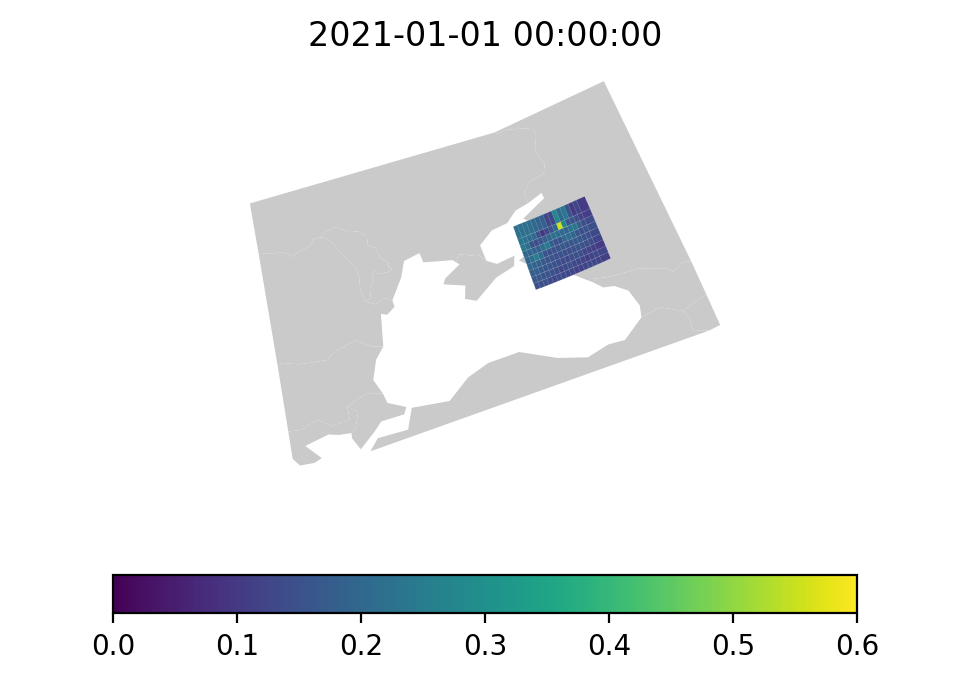

In [15]:
plot_map(df[df['date']=='2021-01-01 00:00:00'], 'value', part_world_to_plot='KK', vmin=0, vmax=0.6, text = '2021-01-01 00:00:00')

## Сохраняем изображения
нужно создать папку anim_future

In [18]:
column = 'value'

vmin = 0
vmax = 0.6

name = 0

for t in list(range(grid_new.shape[0]))[::day_interval]:
    date = str(start_date + pd.DateOffset(1) * t)
    plot_map(df[df['date'] == date], column, part_world_to_plot='KK', vmin=vmin, vmax=vmax, 
             img_path=f'anim_future/{name}.jpg', text = date,
             show=False)
    name+=1
    plt.close()

# Собираем картинки в .h265 файл

In [19]:
!ffmpeg -start_number 0 -framerate 10 -i anim_future/%d.jpg future_full.h264

ffmpeg version 9c33b2f Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.3.0 (crosstool-NG 1.24.0.133_b0863d8_dirty)
  configuration: --prefix=/home/a.kurdyukova/anaconda3/envs/torch_env --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1627813612080/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample  